# US Wildfire -- Exploratory Data Analysis

# 1. Data Cleaning

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import datetime
import folium
from folium.plugins import HeatMap
from folium import plugins
import seaborn as sns
plt.style.use('seaborn-bright')

import warnings
warnings.filterwarnings("ignore")

In [5]:
#import file
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
query = '''Select 
            FIRE_YEAR,
            DISCOVERY_DATE,
            DISCOVERY_DOY,
            DISCOVERY_TIME,
            STAT_CAUSE_DESCR,
            CONT_DOY,
            FIRE_SIZE,
            FIRE_SIZE_CLASS,
            LATITUDE,
            LONGITUDE,
            STATE,COUNTY,
            FIPS_CODE,
            FIPS_NAME 
                from fires'''
df = pd.read_sql_query(query,conn)

In [3]:
#Change Julian time to standard
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
#extract hr only
df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].str.slice(0,2)
#create month
df['Month'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
#create dayofweek
df['Dayofweek'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek
# other features have already covered this
df.drop('DISCOVERY_DATE',axis = 1, inplace = True)
#It is no use in analysis
df.drop(['COUNTY','FIPS_CODE','FIPS_NAME'],axis = 1,inplace = True)
#Fire duration
df['CONT_DOY'] = df['CONT_DOY'] - df['DISCOVERY_DOY'] #Find the difference between discovery and cont_doy


#Classified causes as four categories
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    arson = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 'natural'
    elif cat in accidental:
        cause = 'accidental'
    elif cat in arson:
        cause = 'arson'
    else:
        cause = 'other'
    return cause
df['LABEL_CAUSE'] = df['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))



#remove temporarily, we should discuss how to deal with this 
#df = df[df['STAT_CAUSE_DESCR'] != 'Missing/Undefined'] #remove unsure cause
#df = df[df['STAT_CAUSE_DESCR'] != 'Miscellaneous']

#Drop all none temporarily, and discuss how to deal with missing value
#df = df.dropna() #just for test 
#df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].astype('int32')


#rearange columns
df = df[['FIRE_YEAR',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'Month',
 'Dayofweek',
 'STATE',
'CONT_DOY',
'FIRE_SIZE',
'LATITUDE',
 'LONGITUDE','STAT_CAUSE_DESCR','LABEL_CAUSE','FIRE_SIZE_CLASS']] #rearange columns

# 2. Data Understanding

# 2.1 Wildfire Cause Analysis

In [4]:
#Dataset for NC state only
df_state = df[df['STATE'] == 'NC']

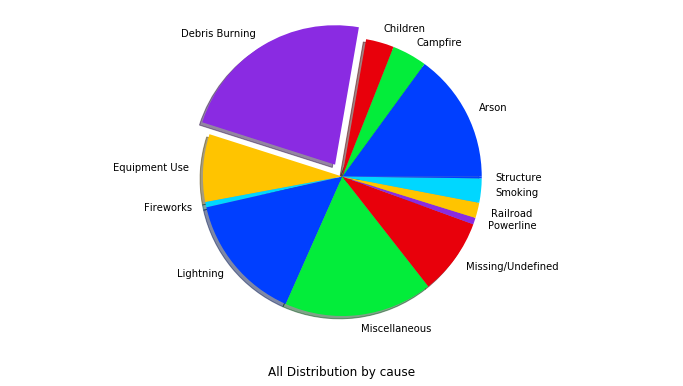

In [5]:
#Pie chart for fire cause
plt.figure(figsize=(12,6))
plt.title('All Distribution by cause', y=-0.15)
data = df.groupby('STAT_CAUSE_DESCR').count().iloc[:,0]
plt.pie(data,labels = data.index,shadow = True,explode = (0,0,0,0.1,0,0,0,0,0,0,0,0,0))
plt.axis('equal');

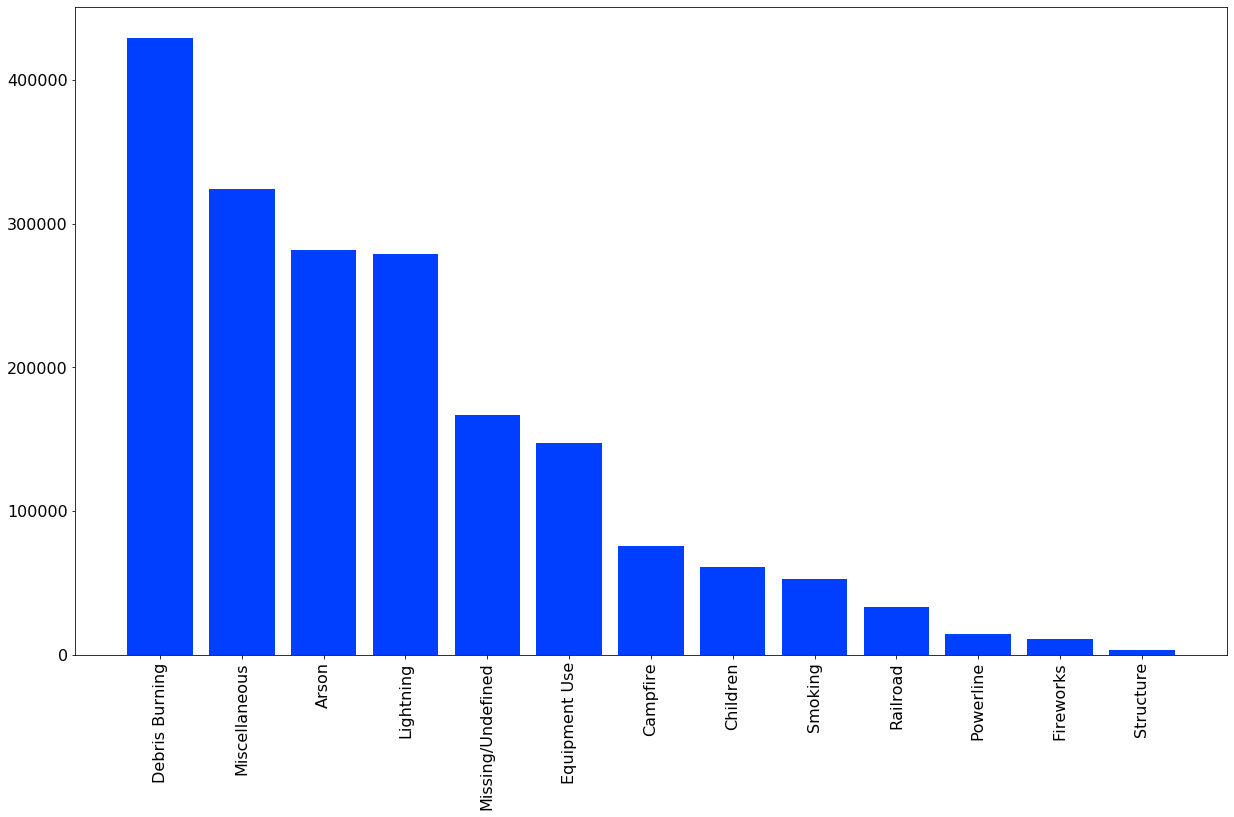

In [6]:
#Bar chart for cause analysis
fig = plt.figure(figsize = (16,9))
ax = fig.add_axes([0,0,1,1])
data = df.groupby('STAT_CAUSE_DESCR').count().iloc[:,0]
data = data.sort_values(ascending = False)
langs = data.index.tolist()
plt.bar(langs,data)
plt.xticks(fontsize=16,rotation = 90)
plt.yticks(fontsize=16)
plt.show()

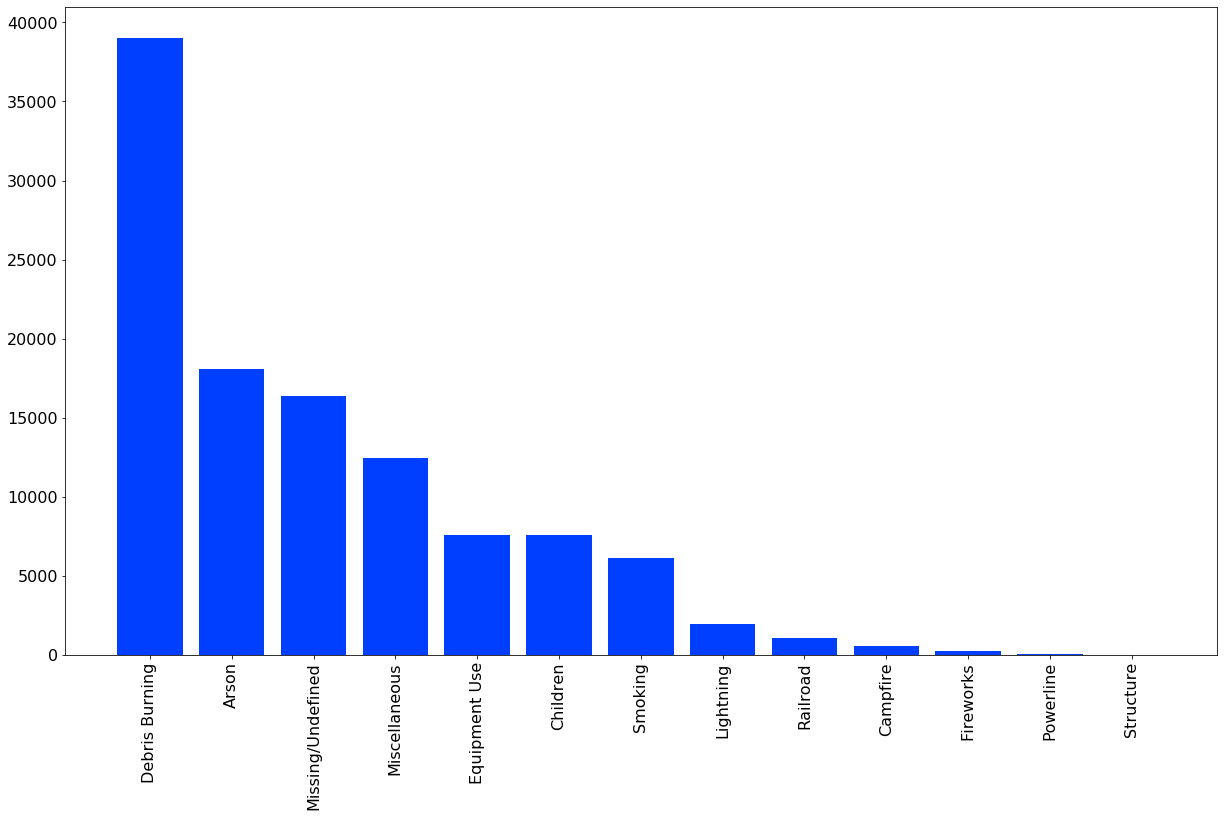

In [7]:
# Bar Chart for NC cause analysis
fig = plt.figure(figsize = (16,9))
ax = fig.add_axes([0,0,1,1])
data = df_state.groupby('STAT_CAUSE_DESCR').count().iloc[:,0]
data = data.sort_values(ascending = False)
langs = data.index.tolist()
plt.xticks(fontsize=16,rotation = 90)
plt.yticks(fontsize=16)
ax.bar(langs,data)
plt.show()

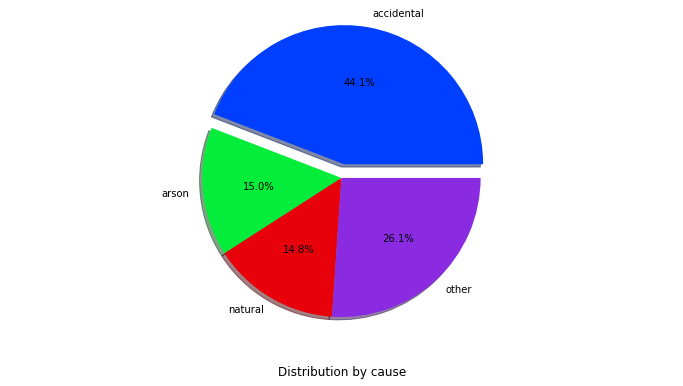

In [8]:
#Pie Chart for four categories
plt.figure(figsize=(12,6))
plt.title('Distribution by cause', y=-0.15)
data = df.groupby('LABEL_CAUSE').count().iloc[:,0]
plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',explode = (0.1,0,0,0))
plt.axis('equal');

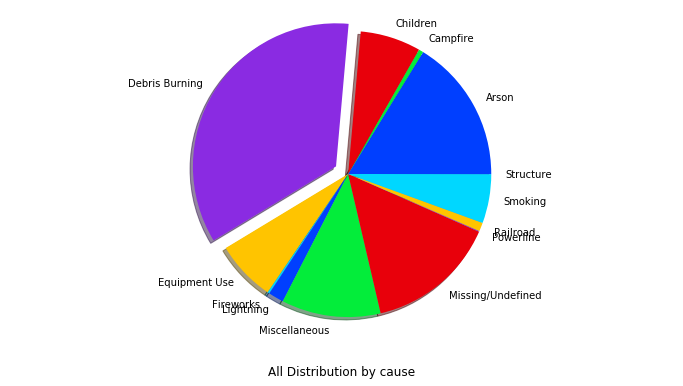

In [9]:
#Pie Chart for NC four categories
plt.figure(figsize=(12,6))
plt.title('All Distribution by cause', y=-0.15)

data = df_state.groupby('STAT_CAUSE_DESCR').count().iloc[:,0]
plt.pie(data,labels = data.index,shadow = True,explode = (0,0,0,0.1,0,0,0,0,0,0,0,0,0))
plt.axis('equal');

# 2.2 Wildfire day of week analysis

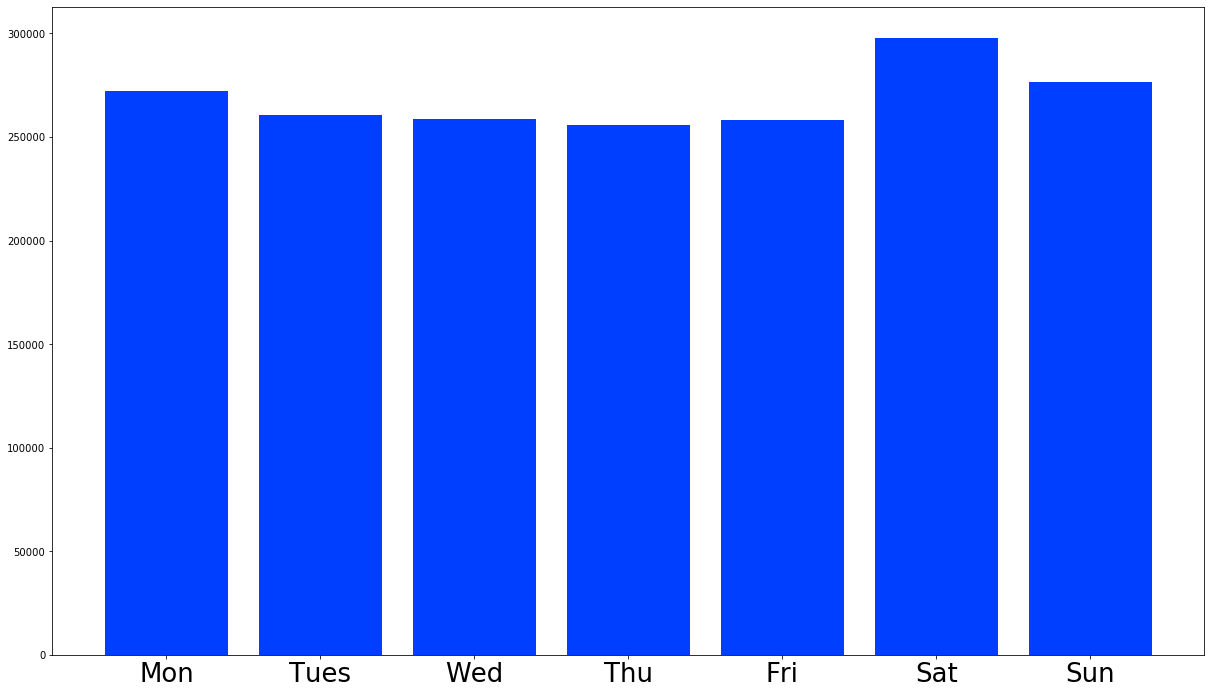

In [10]:
#Day of week analysis
fig = plt.figure(figsize = (16,9))
ax = fig.add_axes([0,0,1,1])
data = df.groupby('Dayofweek').count().iloc[:,0]
langs = data.index.tolist()
ax.bar(langs,data)
ax.set_xticklabels(['','Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],fontsize = 26)
plt.show()

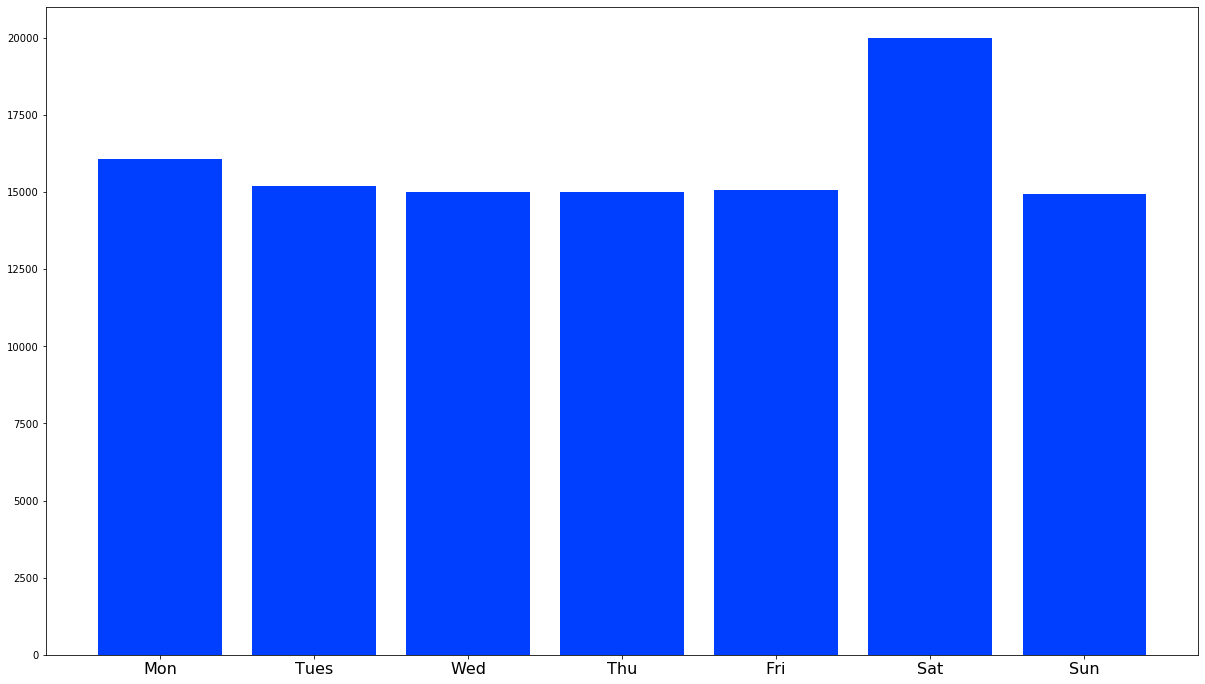

In [11]:
#NC Day of week analysis
fig = plt.figure(figsize = (16,9))
ax = fig.add_axes([0,0,1,1])
data = df_state.groupby('Dayofweek').count().iloc[:,0]
langs = data.index.tolist()
ax.bar(langs,data)
ax.set_xticklabels(['','Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],fontsize = 16)
plt.show()

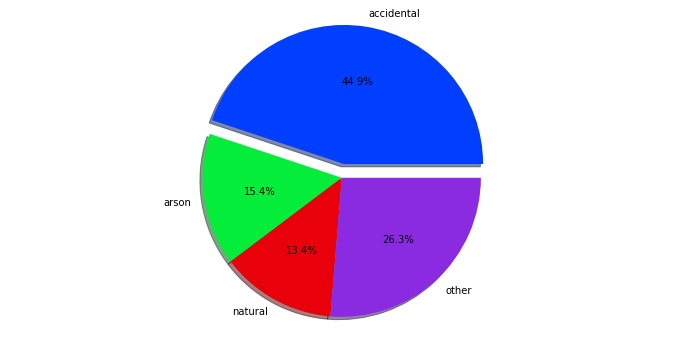

In [12]:
#Pie chart cause analysis(weekend only)
plt.figure(figsize=(12,6))
data = df[df['Dayofweek'] >=5] #weekend only
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',explode = (0.1,0,0,0))
plt.axis('equal');

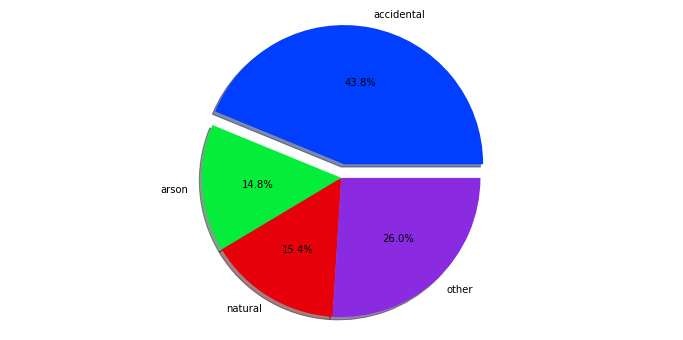

In [13]:
#Pie chart cause analysis(weekday only)
plt.figure(figsize=(12,6))
data = df[df['Dayofweek'] < 5] #weekday only
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',explode = (0.1,0,0,0))
plt.axis('equal');

# 2.3 Most Frequent Month Analysis

In [14]:
monthbystate = df.groupby(['STATE','Month'])[['FIRE_YEAR']].count().sort_values(by = 'FIRE_YEAR').groupby(level=0).tail(1)
monthbystate.reset_index(inplace = True)

In [15]:
monthbystate

,STATE,Month,FIRE_YEAR
0,DC,3,14
1,DE,4,43
2,RI,4,187
3,VT,4,208
4,IN,4,412
5,IL,3,637
6,MD,3,836
7,NH,4,996
8,MA,5,1044
9,OH,3,1055


In [16]:
m = folium.Map(location = [40,-95],zoom_start = 5,tiles = "Stamen Terrain")
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
folium.Choropleth(geo_data=state_geo,name="choropleth",columns = ['STATE','Month'],key_on = 'feature.id',data = monthbystate,fill_color="YlOrRd",fill_opacity=0.7,
    line_opacity=.1,legend_name="Most Frequent Month").add_to(m)
folium.LayerControl().add_to(m)
m

# 2.4 Fire burned area analysis by Fire size class

In [17]:
byclass = df.groupby(['FIRE_SIZE_CLASS','STAT_CAUSE_DESCR'])['FIRE_YEAR'].count()
byclass = byclass.reset_index()

In [18]:
byclass[byclass['FIRE_SIZE_CLASS']=='G']

,FIRE_SIZE_CLASS,STAT_CAUSE_DESCR,FIRE_YEAR
78,G,Arson,155
79,G,Campfire,86
80,G,Children,10
81,G,Debris Burning,115
82,G,Equipment Use,199
83,G,Fireworks,6
84,G,Lightning,2419
85,G,Miscellaneous,416
86,G,Missing/Undefined,253
87,G,Powerline,64


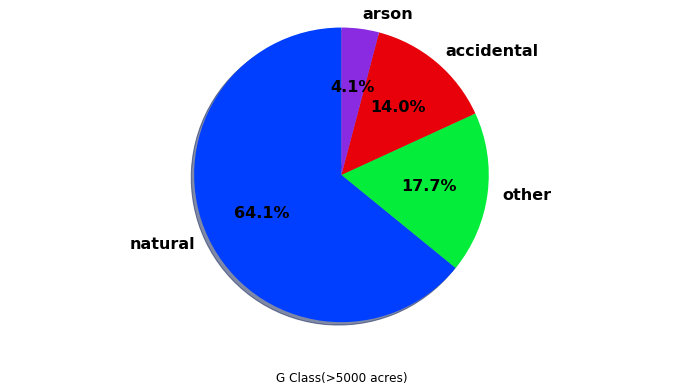

In [19]:
#G-Class
plt.figure(figsize=(12,6))
plt.title('G Class(>5000 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'G']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

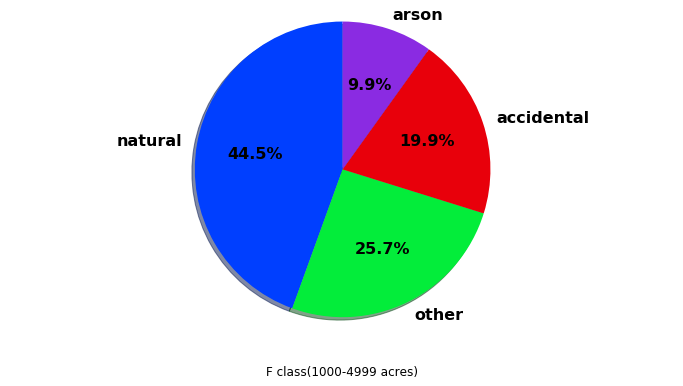

In [20]:
#F-class
plt.figure(figsize=(12,6))
plt.title('F class(1000-4999 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'F']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

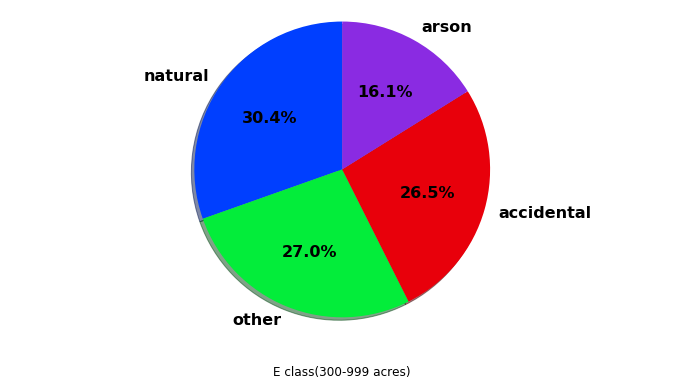

In [21]:
#E-class
plt.figure(figsize=(12,6))
plt.title('E class(300-999 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'E']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

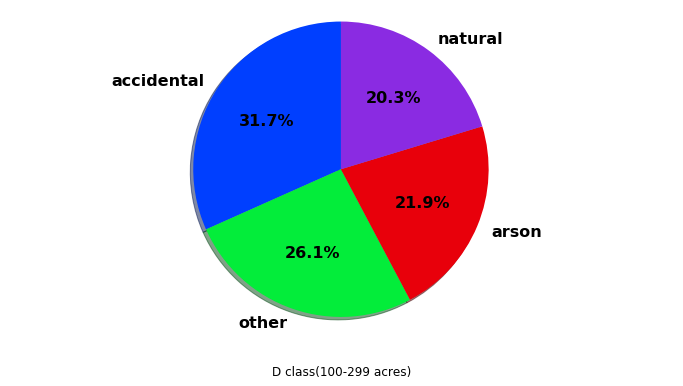

In [22]:
#D-class
plt.figure(figsize=(12,6))
plt.title('D class(100-299 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'D']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

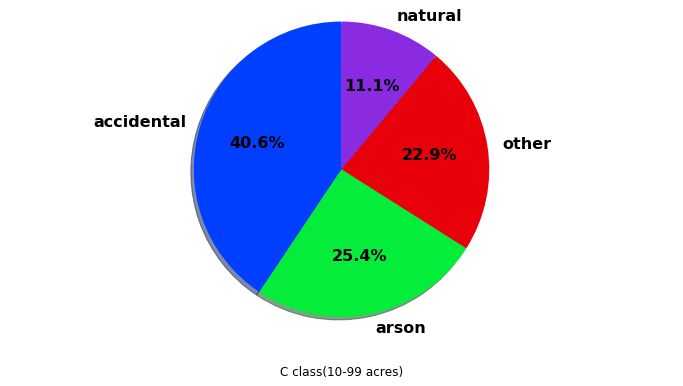

In [23]:
#C-class
plt.figure(figsize=(12,6))
plt.title('C class(10-99 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'C']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

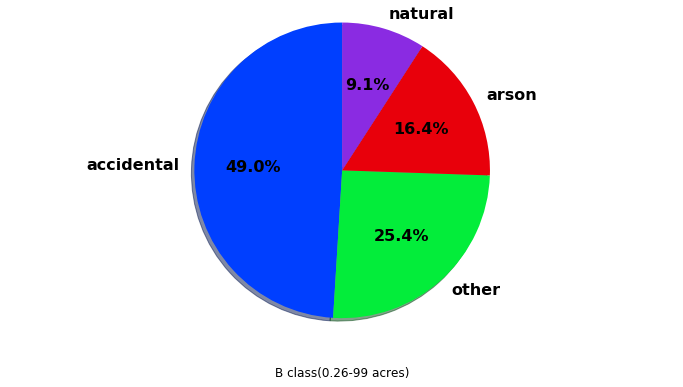

In [24]:
#B-class
plt.figure(figsize=(12,6))
plt.title('B class(0.26-99 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'B']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

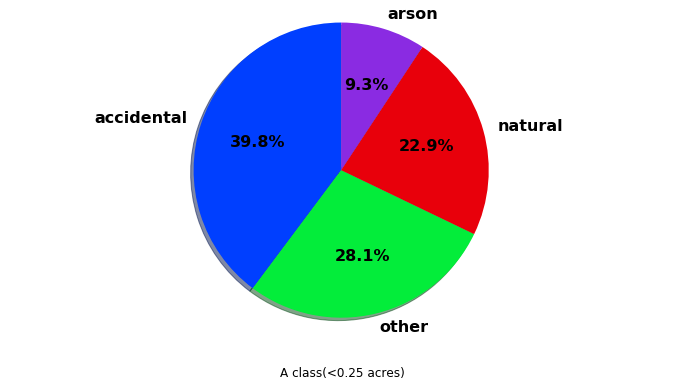

In [25]:
#A-class
plt.figure(figsize=(12,6))
plt.title('A class(<0.25 acres)', y=-0.15)
data = df[df['FIRE_SIZE_CLASS'] == 'A']
data = data.groupby('LABEL_CAUSE').count().iloc[:,0]
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

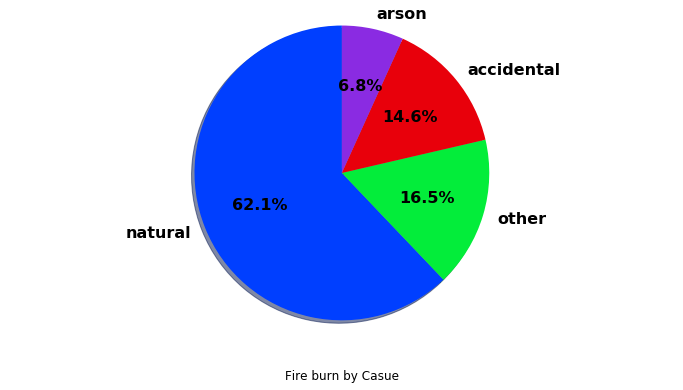

In [26]:
#Fire burned by Cause
area = df.groupby('LABEL_CAUSE')['FIRE_SIZE'].sum()
plt.figure(figsize=(12,6))
plt.title('Fire burn by Casue', y=-0.15)
data = area
data = data.sort_values(ascending = False)
wedges1, texts1, autotexts1 = plt.pie(data,labels = data.index,shadow = True,autopct='%1.1f%%',startangle = 90)
plt.setp(autotexts1, size=16, weight="bold")
plt.setp(texts1, size=16, weight="bold")
plt.axis('equal');

# 2.5 US wildfire Year and Month Heatmap

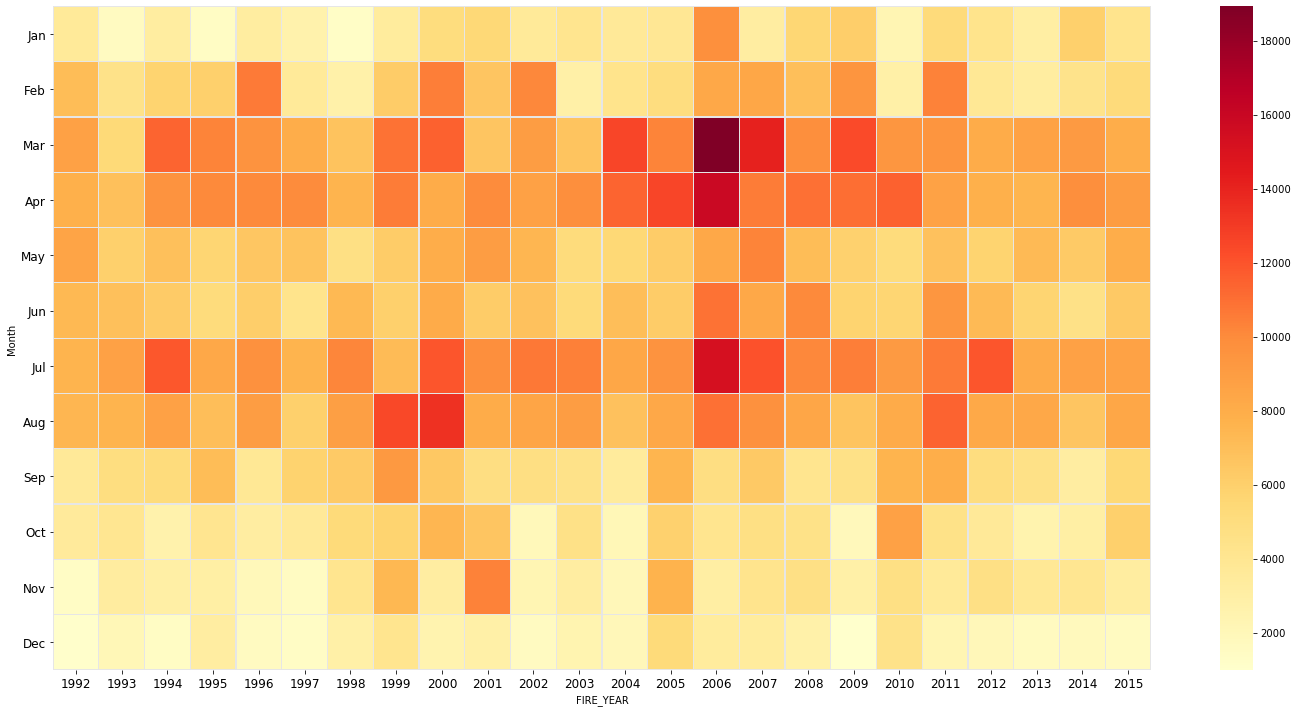

In [28]:
df_mon_year = df.groupby(['Month', 'FIRE_YEAR']).size().unstack()
counter_fig = 1
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize = [20, 10])
sns.heatmap(df_mon_year, cmap = 'YlOrRd', linewidth=.2, linecolor=[0.9, 0.9, 0.9])
plt.yticks(np.arange(0.5, 12.5), labels = month, rotation = 0, fontsize = 12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

### 3.1 Data Preprocessing

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [43]:
#import file
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
query = '''Select 
            FIRE_YEAR,
            DISCOVERY_DATE,
            DISCOVERY_DOY,
            DISCOVERY_TIME,
            STAT_CAUSE_DESCR,
            FIRE_SIZE,
            FIRE_SIZE_CLASS,
            LATITUDE,
            LONGITUDE,
            STATE 
                from fires'''
df = pd.read_sql_query(query,conn)

In [ ]:
df = pd.read_sql_query(query,conn)
# Data cleaning

#Change Julian time to standard
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
#extract hr only
df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].str.slice(0,2)
#create month
df['Month'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
#create dayofweek
df['Dayofweek'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek
# other features have already covered this
df.drop('DISCOVERY_DATE',axis = 1, inplace = True)
# #It is no use in analysis
# df.drop(['COUNTY','FIPS_CODE','FIPS_NAME'],axis = 1,inplace = True)
# #Fire duration
# df['CONT_DOY'] = df['CONT_DOY'] - df['DISCOVERY_DOY'] #Find the difference between discovery and cont_doy

#remove temporarily, we should discuss how to deal with this 
df = df[df['STAT_CAUSE_DESCR'] != 'Missing/Undefined'] #remove unsure cause
#df = df[df['STAT_CAUSE_DESCR'] != 'Miscellaneous']

#Drop all none temporarily, and discuss how to deal with missing value
df = df.dropna() 
df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].astype('int32')

#rearange columns
df = df[['FIRE_YEAR',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'Dayofweek',
 'Month',
 'STATE',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE','STAT_CAUSE_DESCR']].reset_index(drop=True) #rearange columns

#create a new column based on the categories of cause
cause_dict = {'Miscellaneous':'Others', 'Lightning':'Natural', 'Arson': 'Arson'}
cause_dict.update(dict.fromkeys(['Debris Burning', 'Campfire', 'Equipment Use', 
                                 'Children', 'Railroad', 'Smoking', 
                                 'Powerline', 'Structure', 'Fireworks'], 'Accidental'))
df['Cause_Cat'] = df['STAT_CAUSE_DESCR'].map(cause_dict)



df = df.drop(columns=['FIRE_SIZE'])
#Select NC only
df = df[df.STATE=='NC'].reset_index(drop=True)
df = df.drop(columns=['STATE'])

#convert categorial features into number
for col in ['FIRE_YEAR','STAT_CAUSE_DESCR','FIRE_SIZE_CLASS','Cause_Cat']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

#Standardized latitude and longitude
standardized = StandardScaler()
df[['LATITUDE','LONGITUDE']] = standardized.fit_transform(df[['LATITUDE','LONGITUDE']])

# 3.2 Ensemble (

In [ ]:
X = np.array(df.drop('FIRE_SIZE_CLASS',axis = 1))
y = np.array(df['FIRE_SIZE_CLASS'])

In [ ]:
#split training set, test set, and validation set
split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.5,random_state = 42)

for train_idx,test_idx in split.split(X,y):
    X_train,X_test = X[train_idx],X[test_idx]
    y_train,y_test = y[train_idx],y[test_idx]

for train_idx,val_idx in split.split(X_train,y_train):
    X_train,X_val = X[train_idx],X[val_idx]
    y_train,y_val = y[train_idx],y[val_idx]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#SVC
clf1 = SVC(C=1.0, kernel='rbf') 
#KNN
clf2 = KNeighborsClassifier(n_neighbors = 5)
#MLP
clf3 = MLPClassifier()

In [ ]:
#Blending Ensemble
y_pred_val = []
y_pred_test = []

for var in [clf1,clf2,clf3]:
    var.fit(X_train,y_train)
    y_pred_val.append(var.predict(X_val))
    y_pred_test.append(var.predict(X_test))
    
    
# Convert the prediction into series
clf1_pred_val = pd.Series(y_pred_val[0])
clf2_pred_val = pd.Series(y_pred_val[1])
clf3_pred_val = pd.Series(y_pred_val[2])

clf1_pred_test = pd.Series(y_pred_test[0])
clf2_pred_test = pd.Series(y_pred_test[1])
clf3_pred_test = pd.Series(y_pred_test[2])

#merge predictions of val and test to X_val and X_test
meta_train = X_val.copy()
meta_test =  X_test.copy()
meta_train = pd.DataFrame(meta_train)
meta_test = pd.DataFrame(meta_test)

for i,var in enumerate([clf1_pred_val,clf2_pred_val,clf3_pred_val]):
    i += 90
    meta_train[i] = var
    
for i,var in enumerate([clf1_pred_test,clf2_pred_test,clf3_pred_test]):
    i += 90
    meta_test[i] = var

In [ ]:
blender = RandomForestClassifier()
blender.fit(meta_train,y_val)
y_pred_blender = blender.predict(meta_test)
print('Accuracy of blender : {:.3f}'.format(accuracy_score(y_test,y_pred_blender)))

In [22]:
# blender = RandomForestClassifier()
# blender.fit(meta_train,y_val)
# y_pred_blender = blender.predict(meta_test)
# print('Accuracy of blender : {:.3f}'.format(accuracy_score(y_test,y_pred_blender)))

Accuracy of blender : 0.695


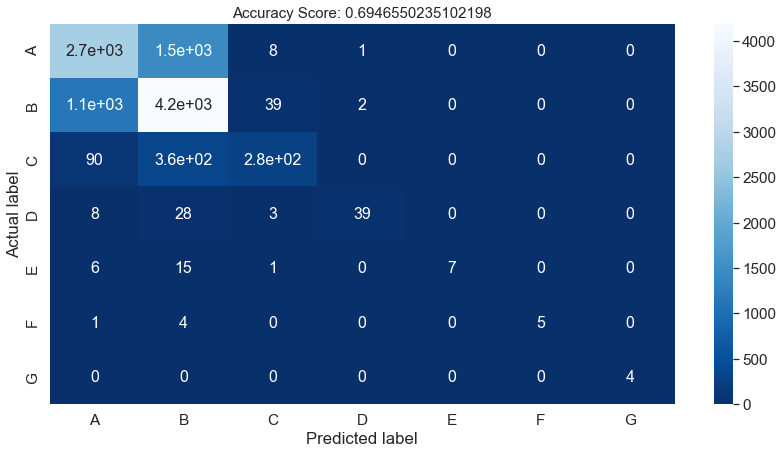

In [41]:
array = confusion_matrix(y_test,y_pred_blender)

df_cm = pd.DataFrame(array, ['A','B','C','D','E','F','G'], ['A','B','C','D','E','F','G'])
plt.figure(figsize=(14,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap = 'Blues_r') # font size
plt.ylabel('Actual label');
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred_blender))
plt.title(all_sample_title, size = 15);
plt.show()

In [24]:
from sklearn.metrics import classification_report
target_names = ['A','B','C','D','E','F','G']
print(classification_report(y_test, y_pred_blender, target_names=target_names))

              precision    recall  f1-score   support

           A       0.68      0.65      0.67      4200
           B       0.69      0.78      0.73      5378
           C       0.84      0.38      0.53       722
           D       0.93      0.50      0.65        78
           E       1.00      0.24      0.39        29
           F       1.00      0.50      0.67        10
           G       1.00      1.00      1.00         4

    accuracy                           0.69     10421
   macro avg       0.88      0.58      0.66     10421
weighted avg       0.70      0.69      0.69     10421

